<a href="https://colab.research.google.com/github/eatPizza311/iThome-2021ironman/blob/main/build_dataflywheel/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 訓練要部署的模型

- 資料：取自 [300 Bird Species - Classification](https://www.kaggle.com/gpiosenka/100-bird-species?select=test)。
- 模型：以 [EfficientNetB0](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0) 作為 Backbone 並搭配不同輸出層。
- 產出：可上傳至 Google Storage 的 [`SaveModel`](https://www.tensorflow.org/guide/saved_model) 格式

In [ ]:
# Is GPU activated?
!nvidia-smi

Fri Oct  1 07:09:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

如果上面 cell 的輸出不是長得像下面那樣 (GPU 可能會不同)：

![nividia-smi output](https://i.imgur.com/0gmKkY2l.png)

請到 執行階段 -> 變更執行階段類型 -> 硬體加速器選擇 "GPU"，然後再重新執行上方的 Cell。

# Setup & 小幫手函式

In [ ]:
import zipfile
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing

import matplotlib.pyplot as plt

tf.__version__

'2.6.0'

## 解壓縮

In [ ]:
def unzip_data(filename):
    """Unzip a zipped file."""
    zip_f = zipfile.ZipFile(filename, 'r')
    zip_f.extractall()
    zip_f.close()

## 資料 Pipeline

In [ ]:
# setup data input
IMG_SIZE = (224, 224)

def data_loader(train_dir, test_dir, image_size=IMG_SIZE):
    """Create a training and testing image Dataset from train_dir and test_dir"""
    train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                     label_mode='categorical',
                                                                     image_size=image_size)
    test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                    label_mode='categorical',
                                                                    image_size=image_size)
    return train_data, test_data

In [ ]:
# create a data augmetaion stage
data_augmentation = keras.Sequential([
                                      preprocessing.RandomFlip("horizontal"),
                                      preprocessing.RandomRotation(0.3),
                                      preprocessing.RandomZoom(0.2),
                                      preprocessing.RandomHeight(0.2),
                                      preprocessing.RandomWidth(0.2)
], name='data_augmentation')

## 結果可視化

In [ ]:
def load_and_prep_image(filename, img_shape=224, scale=False):
    """Converts a JPEG image to a tesor of shape (224, 224, 3)"""
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [img_shape, img_shape])
    if scale:
        return img/255.
    else:
        return img

In [ ]:
def pred_and_plot(model, filename, class_names):
    img = load_and_prep_image(filename)
    img = tf.cast(tf.round(img), dtype=tf.int32)
    pred_probs = model.predict(tf.expand_dims(img, axis=0))
    pred_class = class_names[tf.argmax(pred_probs[0])]
    plt.figure()
    plt.imshow(img)
    plt.title(f"{pred_class}, prob: {tf.reduce_max(pred_probs):.2f}")
    plt.axis(False);

## 建立模型

In [ ]:
# setup input shape and base model
INPUT_SHAPE = (224, 224, 3)
BASE_MODEL = tf.keras.applications.EfficientNetB0(include_top=False)

def build_model(input_shape=INPUT_SHAPE, base_model=BASE_MODEL, num_classes=10):
    # Unfreeze the base model if fine-tune is needed
    # see: https://keras.io/guides/transfer_learning/ for more detail
    base_model.trainable = False

    # create input layer
    inputs = keras.layers.Input(shape=input_shape, name='inputs')
    # using augmetation Sequential model as a layers
    x = data_augmentation(inputs)

    # The base model contains batchnorm layers. We want to keep them in inference mode
    # when we unfreeze the base model for fine-tuning, so we make sure that the
    # base_model is running in inference mode here.
    x = base_model(x, training=False)
    x = keras.layers.GlobalAveragePooling2D(name='global_avg_pooling')(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax', name='outputs')(x)

    # create model
    model = keras.Model(inputs, outputs)

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])
    return model

16719872/16705208 [==============================] - 0s 0us/step


# 下載資料

In [ ]:
# Download data — 10 class subset of 300 Bird Species - Classification (https://www.kaggle.com/gpiosenka/100-bird-species?select=test)
# Already formatted in standard image classification directory style
path = "10_bird_classes_all_data.zip"
if not os.path.isfile(path):
    !wget https://storage.googleapis.com/ironbird_2021/10_bird_classes_all_data.zip
    unzip_data(path)
else:
    print("File already exist.")

--2021-10-01 07:10:07--  https://storage.googleapis.com/ironbird_2021/10_bird_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 66.102.1.128, 172.253.120.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34734704 (33M) [application/zip]
Saving to: ‘10_bird_classes_all_data.zip’

10_bird_classes_all 100%[===================>]  33.12M  11.8MB/s    in 2.8s    

2021-10-01 07:10:14 (11.8 MB/s) - ‘10_bird_classes_all_data.zip’ saved [34734704/34734704]



In [ ]:
# Walk through all data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_bird_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_bird_classes_all_data'.
There are 10 directories and 0 images in '10_bird_classes_all_data/test'.
There are 0 directories and 10 images in '10_bird_classes_all_data/test/TAIWAN MAGPIE'.
There are 0 directories and 10 images in '10_bird_classes_all_data/test/MALLARD DUCK'.
There are 0 directories and 10 images in '10_bird_classes_all_data/test/ROCK DOVE'.
There are 0 directories and 10 images in '10_bird_classes_all_data/test/MYNA'.
There are 0 directories and 10 images in '10_bird_classes_all_data/test/BARN SWALLOW'.
There are 0 directories and 10 images in '10_bird_classes_all_data/test/EURASIAN MAGPIE'.
There are 0 directories and 10 images in '10_bird_classes_all_data/test/MANDRIN DUCK'.
There are 0 directories and 10 images in '10_bird_classes_all_data/test/HOUSE SPARROW'.
There are 0 directories and 10 images in '10_bird_classes_all_data/test/MALAGASY WHITE EYE'.
There are 0 directories and 10 images in '10_bird_classes_all_data/test/SWI

# 實驗管理 (Experiment tracking)

因為我們可能會進行多次的實驗，所以最好將與實驗相關的資訊整理起來，這裡我們使用 Tensorboard 作為實驗管理的工具。

Tensorboard 是 TensorFlow 內建的互動式視覺化工具，可以用來看訓練時的學習曲線、比較不同次執行的學習曲線、視覺化計算圖、分析訓練統計值、看模型生成的圖、視覺化高維資料投影到 3D 的圖，還有自動分群等功能。

要使用它必須讓程式把資料輸出至被稱為 event file 的 binary log 檔，而每個二元資料紀錄 (binary data record) 則稱為 summary。

而 TensorBoard server 會監看 log 資料夾，並自動把任何改變更新至視覺化上。

使用時只需要把 TensorBoard server 指向 root log directory，然後讓程式每次執行時可以寫入不同的子資料夾，這樣我們就能比較不同次執行的資料了，這裡我們會以 `[dir_name]/[experiment_name]/[current_timestamp]` 作為資料夾名稱的格式，其中：
- `dir_name` 為存放所有 log 的資料夾
- `experiment_name` 為特定實驗的名稱
- `current_timestamp` 為實驗開始的時間，作為其獨特的 id

當然資料夾名稱可以包含更多資訊，例如正在實驗的超參數值…，讓我們可以更清楚目前在做什麼。

In [ ]:
def create_tensorboard_callback(dir_name, experiment_name):
    import time
    import os
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S") # e.g., 'run_2019_06_07-15_15_22'
    log_dir = os.path.join(dir_name, experiment_name, run_id)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

這樣就可以使用了，如果我們執行這個程式，`TensorBoard()` callback 就會幫我們創造資料夾，還有在訓練時創造 event files 並為其寫入 summaries。

如果再執行上面的程式一次，我們就可以得到類似下面的資料夾結構：
```
transfer_learning/
├── all_data_aug
│   ├── run_2021_10_01-05_28_53
│   │   ├── train
│   │   │   ├── events.out.tfevents.1633066133.bd3338481908.367.0.v2
│   │   │   ├── events.out.tfevents.1633066172.bd3338481908.profile-empty
│   │   │   └── plugins/profile/2021_10_01_05_29_32
│   │   │       └── local.trace
│   │   └── validation
│   │       └── events.out.tfevents.1633066196.bd3338481908.367.1.v2
│   └── run_2021_10_01-05_29_12
│       └── [...]
└── other_aug
    └── [...]
```

每次執行就會有一個新的資料夾產生，其中包含存有訓練與驗證 logs 資訊的子資料夾各一個，子資料夾裡則有 event files，而 training logs 還會包含profiling traces，這可以讓 TensorBoard 顯示模型每個部份實際花了多少時間，因此能找到 performance 的瓶頸。

# 模型 1 (10 種鳥類)

In [ ]:
# create dataset
train_data, test_data = data_loader(train_dir="10_bird_classes_all_data/train/",
                                    test_dir="10_bird_classes_all_data/test/")

Found 1446 files belonging to 10 classes.
Found 100 files belonging to 10 classes.


In [ ]:
# create model
model_1 = build_model(num_classes=len(train_data.class_names))

# fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[create_tensorboard_callback("transfer_learning", "all_data_aug")])

Saving TensorBoard log files to: transfer_learning/all_data_aug/run_2021_10_01-07_42_35
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 25s 393ms/step - loss: 1.2667 - accuracy: 0.6943 - val_loss: 0.5051 - val_accuracy: 0.9900
Epoch 2/5
46/46 [==============================] - 16s 351ms/step - loss: 0.3887 - accuracy: 0.9557 - val_loss: 0.2134 - val_accuracy: 1.0000
Epoch 3/5
46/46 [==============================] - 15s 320ms/step - loss: 0.2182 - accuracy: 0.9758 - val_loss: 0.1293 - val_accuracy: 1.0000
Epoch 4/5
46/46 [==============================] - 15s 317ms/step - loss: 0.1661 - accuracy: 0.9765 - val_loss: 0.0895 - val_accuracy: 1.0000
Epoch 5/5
46/46 [==============================] - 15s 330ms/step - loss: 0.1198 - accuracy: 0.9876 - val_loss: 0.0676 - val_accuracy: 1.0000


In [ ]:
# Get an image Tensor
!wget -O swallow.jpg https://i.imgur.com/gmWCatX.jpg

--2021-10-01 07:52:05--  https://i.imgur.com/gmWCatX.jpg
Resolving i.imgur.com (i.imgur.com)... 151.101.16.193
Connecting to i.imgur.com (i.imgur.com)|151.101.16.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36642 (36K) [image/jpeg]
Saving to: ‘swallow.jpg’

swallow.jpg         100%[===================>]  35.78K  --.-KB/s    in 0.001s  

2021-10-01 07:52:05 (26.2 MB/s) - ‘swallow.jpg’ saved [36642/36642]



In [ ]:
# Classes our model is trained on
class_names = train_data.class_names
class_names

['BARN SWALLOW',
 'EURASIAN MAGPIE',
 'HOUSE SPARROW',
 'MALAGASY WHITE EYE',
 'MALLARD DUCK',
 'MANDRIN DUCK',
 'MYNA',
 'ROCK DOVE',
 'SWINHOES PHEASANT',
 'TAIWAN MAGPIE']

In [ ]:
# Preprocess image
swallow_img = load_and_prep_image("swallow.jpg")
swallow_img = tf.cast(tf.round(swallow_img), dtype=tf.int32)

In [ ]:
# Make predictions
swallow_expanded = tf.expand_dims(swallow_img, axis=0) # expand image dimensions (224, 224, 3) -> (1, 224, 224, 3)
pred = model_1.predict(swallow_expanded)
pred

array([[6.9924557e-01, 2.9763216e-02, 1.0621327e-01, 2.2199344e-02,
        2.7449389e-03, 2.3054064e-04, 4.8257306e-02, 1.7451604e-03,
        1.3945761e-02, 7.5654894e-02]], dtype=float32)

In [ ]:
# Check the predicted class
class_names[tf.argmax(pred[0])]

'BARN SWALLOW'

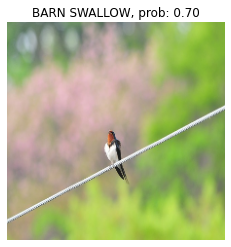

In [ ]:
pred_and_plot(model=model_1,
              filename="swallow.jpg",
              class_names=train_data.class_names)

## 儲存 Model_1 並把它上傳至 Google Storage
我們會把模型存為 Tensorflow [`SavedModel`](https://www.tensorflow.org/guide/saved_model) 格式，這是因為:

1. 我們要把 `SavedModel` 上傳到 Google Storage
2. 再把 `SavedModel` 與 AI 平台連接以部署它 (AI 平台需要這個格式，請參考 [Deploying models](https://cloud.google.com/ai-platform/prediction/docs/deploying-models)) 

所以底下我們會先使用 `model.save("PATH_TO_SAVED_MODEL")` 來創造 `SavedModel`，然後再依照 [Uploading objects](https://cloud.google.com/storage/docs/uploading-objects#gsutil) 將其上傳。

In [ ]:
# Save model_1
model_1.save("efficientnet_model_1_10_classes")

INFO:tensorflow:Assets written to: efficientnet_model_1_10_classes/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


以下幾個 Cell 能讓我們直接在 Colab 把檔案傳到 Google Storage。

In [ ]:
# Authentic Colab
# (Running this will give you a code to authentic your Google Colab instance, keep the verification code secret)
from google.colab import auth
auth.authenticate_user()

執行下面的 Cell 時，會被問很多與設定 gcloud 相關的問題，以下是會被問到的問題與我的回答 (選擇自己的 Google Cloud project)
```
# Pick configuration to use:
#  [1] Re-initialize this configuration [default] with new settings 
#  [2] Create a new configuration
# Please enter your numeric choice:  1

# Choose the account you would like to use to perform operations for 
this configuration:
#  [1] spacetime0311@gmail.com
#  [2] Log in with a new account
# Please enter your numeric choice:  1

# Pick cloud project to use: 
#  [1] civic-capsule-327205
#  [2] data-button-305900
#  [3] first-haven-327205
#  [4] ironman-327706
#  [5] Create a new project
# Please enter numeric choice or text value (must exactly match list 
# item):  4
```

In [ ]:
# Install and initialize the gcloud command line tool - https://cloud.google.com/sdk/docs/install
# (this will give you access to gcloud tools within Colab)
!curl https://sdk.cloud.google.com | bash 1> /dev/null
!gcloud init

完成上面 Cell 之後，我們就可以在 Colab 使用 gcloud utilities 了。

這裡需要的功能是把我們訓練好的模型上傳到 Google Storage，例如執行：
```
# Copy local model folder to bucket named "ml_deployment_lec_bucket_0"
!gsutil cp -r efficientnet_model_1_10_classes gs://ironbird_2021
```
但這邊用的是我的值區 (bucket) 與模型，要記得做相對應的改動：
```
!gsutil cp -r YOUR_MODEL_NAME gs://YOUR_BUCKET_NAME
```
> **注意**：要把任何東西傳到值區的前提是它要存在，請參考 [Creating storage buckets](https://cloud.google.com/storage/docs/creating-buckets) 來建立值區。


In [ ]:
# Copy model to bucket - https://cloud.google.com/storage/docs/uploading-objects#gsutil 
# Use "-r" for folders (r stands for recursive)
!gsutil cp -r efficientnet_model_1_10_classes gs://ironbird_2021

# 模型 2 (11 種鳥類)
所有做法都跟模型 1 相同，只是加上了朱鷺 (Crested ibis)

## 下載資料

In [ ]:
## Download data — 10 class subset of 300 Bird Species - Classification (https://www.kaggle.com/gpiosenka/100-bird-species?select=test)
# Already formatted in standard image classification directory style
path = "11_bird_classes_all_data.zip"
if not os.path.isfile(path):
    !wget https://storage.googleapis.com/ironbird_2021/11_bird_classes_all_data.zip
    unzip_data(path)
else:
    print("File already exist.")

--2021-10-01 07:45:44--  https://storage.googleapis.com/ironbird_2021/11_bird_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 74.125.140.128, 108.177.15.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38434723 (37M) [application/zip]
Saving to: ‘11_bird_classes_all_data.zip’

11_bird_classes_all 100%[===================>]  36.65M  13.6MB/s    in 2.7s    

2021-10-01 07:45:50 (13.6 MB/s) - ‘11_bird_classes_all_data.zip’ saved [38434723/38434723]



In [ ]:
# create dataset
train_data, test_data = data_loader(train_dir="11_bird_classes_all_data/train/",
                                    test_dir="11_bird_classes_all_data/test/")

Found 1602 files belonging to 11 classes.
Found 110 files belonging to 11 classes.


In [ ]:
# Classes our model is trained on
class_names = train_data.class_names
class_names

['ASIAN CRESTED IBIS',
 'BARN SWALLOW',
 'EURASIAN MAGPIE',
 'HOUSE SPARROW',
 'MALAGASY WHITE EYE',
 'MALLARD DUCK',
 'MANDRIN DUCK',
 'MYNA',
 'ROCK DOVE',
 'SWINHOES PHEASANT',
 'TAIWAN MAGPIE']

In [ ]:
# Create model
model_2 = build_model(num_classes=len(train_data.class_names))

# Fit model
history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[create_tensorboard_callback("transfer_learning", "all_data_aug_2")])

Saving TensorBoard log files to: transfer_learning/all_data_aug_2/run_2021_10_01-07_48_12
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


51/51 [==============================] - 28s 405ms/step - loss: 1.2066 - accuracy: 0.7522 - val_loss: 0.4362 - val_accuracy: 0.9818
Epoch 2/5
51/51 [==============================] - 17s 320ms/step - loss: 0.3541 - accuracy: 0.9582 - val_loss: 0.1864 - val_accuracy: 0.9909
Epoch 3/5
51/51 [==============================] - 16s 310ms/step - loss: 0.2057 - accuracy: 0.9744 - val_loss: 0.1160 - val_accuracy: 1.0000
Epoch 4/5
51/51 [==============================] - 15s 289ms/step - loss: 0.1468 - accuracy: 0.9856 - val_loss: 0.0798 - val_accuracy: 1.0000
Epoch 5/5
51/51 [==============================] - 15s 286ms/step - loss: 0.1152 - accuracy: 0.9881 - val_loss: 0.0591 - val_accuracy: 1.0000


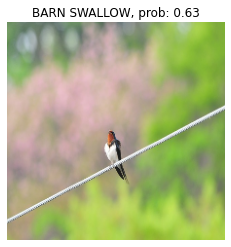

In [ ]:
pred_and_plot(model=model_2,
              filename="swallow.jpg",
              class_names=train_data.class_names)

## 儲存 Model_2 並把它上傳至 Google Storage

In [ ]:
# Save model_2...
model_2.save("efficientnet_model_2_11_classes")

INFO:tensorflow:Assets written to: efficientnet_model_2_11_classes/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
# Upload to GS (requires auth)
!gsutil cp -r efficientnet_model_2_11_classes gs://ironbird_2021

# 模型 3 (11 種鳥類 + 130 張非鳥類圖片，共 12 種類別)

- 跟模型 2 一樣有 11 種鳥類
- 1 個 NOT_BIRD 類別，共 130 張由 ImageNet 下載下來的圖片 (下載請參考 https://github.com/mf1024/ImageNet-Datasets-Downloader)


In [ ]:
## Download data — 10 class subset of 300 Bird Species - Classification (https://www.kaggle.com/gpiosenka/100-bird-species?select=test)
# Already formatted in standard image classification directory style
path = "11_bird_classes_plus_not_bird_all_data.zip"
if not os.path.isfile(path):
    !wget https://storage.googleapis.com/ironbird_2021/11_bird_classes_plus_not_bird_all_data.zip
    unzip_data(path)
else:
    print("File already exist.")

--2021-10-01 07:56:52--  https://storage.googleapis.com/ironbird_2021/11_bird_classes_plus_not_bird_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 66.102.1.128, 142.251.5.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47793562 (46M) [application/zip]
Saving to: ‘11_bird_classes_plus_not_bird_all_data.zip’

11_bird_classes_plu 100%[===================>]  45.58M  12.7MB/s    in 3.6s    

2021-10-01 07:56:59 (12.7 MB/s) - ‘11_bird_classes_plus_not_bird_all_data.zip’ saved [47793562/47793562]



In [ ]:
# create dataset
train_data, test_data = data_loader(train_dir="11_bird_classes_plus_not_bird_all_data/train/",
                                    test_dir="11_bird_classes_plus_not_bird_all_data/test/")

Found 1732 files belonging to 12 classes.
Found 120 files belonging to 12 classes.


In [ ]:
# Classes our model is trained on
class_names = train_data.class_names
class_names

['ASIAN CRESTED IBIS',
 'BARN SWALLOW',
 'EURASIAN MAGPIE',
 'HOUSE SPARROW',
 'MALAGASY WHITE EYE',
 'MALLARD DUCK',
 'MANDRIN DUCK',
 'MYNA',
 'NOT BIRD',
 'ROCK DOVE',
 'SWINHOES PHEASANT',
 'TAIWAN MAGPIE']

In [ ]:
# Create model
model_3 = build_model(num_classes=len(train_data.class_names))

# Fit model
history_3 = model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[create_tensorboard_callback("transfer_learning", "all_data_aug_3")])

Saving TensorBoard log files to: transfer_learning/all_data_aug_3/run_2021_10_01-07_57_01
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


55/55 [==============================] - 26s 344ms/step - loss: 1.3170 - accuracy: 0.7130 - val_loss: 0.5367 - val_accuracy: 0.9500
Epoch 2/5
55/55 [==============================] - 15s 271ms/step - loss: 0.4073 - accuracy: 0.9469 - val_loss: 0.2664 - val_accuracy: 0.9750
Epoch 3/5
55/55 [==============================] - 16s 286ms/step - loss: 0.2458 - accuracy: 0.9688 - val_loss: 0.1839 - val_accuracy: 0.9833
Epoch 4/5
55/55 [==============================] - 14s 244ms/step - loss: 0.1847 - accuracy: 0.9723 - val_loss: 0.1366 - val_accuracy: 0.9917
Epoch 5/5
55/55 [==============================] - 15s 266ms/step - loss: 0.1358 - accuracy: 0.9792 - val_loss: 0.1156 - val_accuracy: 0.9917


In [ ]:
model_3.evaluate(test_data)

4/4 [==============================] - 1s 116ms/step - loss: 0.1156 - accuracy: 0.9917


[0.11558742821216583, 0.9916666746139526]

In [ ]:
# Save model_3...
model_3.save("efficientnet_model_3_12_classes")

In [ ]:
# Upload to GS (requires auth)
!gsutil cp -r efficientnet_model_3_12_classes gs://ironbird_2021

In [ ]:
# Get an image Tensor
!wget -O dessert.jpg https://i.imgur.com/ZUIZfR3.jpg

--2021-10-01 07:58:54--  https://i.imgur.com/ZUIZfR3.jpg
Resolving i.imgur.com (i.imgur.com)... 151.101.16.193
Connecting to i.imgur.com (i.imgur.com)|151.101.16.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102608 (100K) [image/jpeg]
Saving to: ‘dessert.jpg’

dessert.jpg         100%[===================>] 100.20K  --.-KB/s    in 0.007s  

2021-10-01 07:58:55 (13.1 MB/s) - ‘dessert.jpg’ saved [102608/102608]



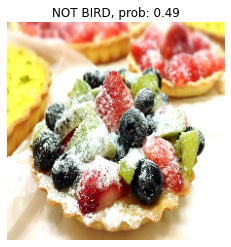

In [ ]:
pred_and_plot(model=model_3,
              filename="dessert.jpg",
              class_names=train_data.class_names)